## Contralateral Bruxism/MEMA analysis

This notebook will 
- Process and generate reports for all the dataset (if needed)
- Display within-subject with contralateral recording of EMG/MEMA results
- Display group analysis differences between effect variables (masking, VAS, etc.) and contralateral differences

In [3]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
print("config loaded")


config loaded


In [1]:
#Setting parameters
results_file_bruxism = "data/reports_and_datas_bruxism.pk"
results_file_mema = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [22]:
results_file_mema = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file_mema).to_dict()
print(results.keys())
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])
results_update=dict()
# e.1 GROUP BY ETIOLOGIES
from tinnsleep.data import read_etiology_file
etiology_file = "data/etiology.xlsx"
etiology = read_etiology_file(etiology_file)



data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & emg==1')
data_info = data_info.merge(etiology,on="subject")

laterality_study=[]
# format reports
reports = None
for filename in results.keys():
    if filename[-4:]=="left":
        if filename!="1SL21_nuit_3.edf_left":
            if filename!='1CB23_cohort2.edf_left':
                if filename!='1HB20_nuit_2.edf_left':
                    if filename!='1UC22_nuit_2.edf_left':
                        if filename!='3KB06_cohort2.edf_left':
                            if filename!='2TL07_nuit_1.edf_left':
            
                                laterality_study.append(filename[:-5])
print(laterality_study)
#print(results.keys())
        
for filename in results.keys():
    if filename[-4:]=="left" or filename[-5:]=="right" or filename == '1HB20_nuit_1.edf' or filename == '1SL21_nuit_2.edf' or filename == '1UC22_nuit_1.edf':
        
        report = pd.DataFrame(results[filename]["reports"])
        report["THR_classif"] = THR_classif[:,1]
        if filename == '1HB20_nuit_1.edf' or filename == '1SL21_nuit_2.edf' or filename == '1UC22_nuit_1.edf':
            report["filename"] = filename+"_right"
        else:
            report["filename"] = filename
        #if filename[:5] == "2TL07":
        #    print(results[filename]["reports"])
        results_update[filename]=results[filename]
        if reports is None:
            reports = report
        else:
            reports = reports.append(report, ignore_index=True)
    
#print(laterality_study)
print(reports[["filename", "Number of MEMA episodes per hour" ]])

data_info["has_left"] = data_info["filename"]
for col_name, data in data_info["filename"].items():
    if laterality_study.__contains__(data):
        data_info["has_left"][col_name]=data+"_left"
    else:
        data_info["has_left"][col_name]=False


data_info = data_info.query('has_left!=False')
print(data_info[["filename", "condition", "mema", "emg","Laterality", "VAS_L_delta", "has_left"]])
results=results_update
#print(data_info)


dict_keys(['1AC26_cohort2.edf_right', '1AC26_cohort2.edf_left', '1AC26_cohort2.edf', '1CB23_cohort2.edf_right', '1CB23_cohort2.edf_left', '1CB23_cohort2.edf', '1DA15_nuit_hab.edf', '1DM32_cohort2.edf_right', '1DM32_cohort2.edf_left', '1DM32_cohort2.edf', '1GB18_nuit_hab.edf', '1GF14_cohort2.edf', '1HB20_nuit_1.edf', '1HB20_nuit_1.edf_left', '1HB20_nuit_2.edf', '1HB20_nuit_2.edf_left', '1HS25_cohort2.edf_right', '1HS25_cohort2.edf_left', '1HS25_cohort2.edf', '1NS30_cohort2.edf_right', '1NS30_cohort2.edf_left', '1NS30_cohort2.edf', '1PA31_cohort2.edf', '1RF29_cohort2.edf_right', '1RF29_cohort2.edf_left', '1RF29_cohort2.edf', '1SL21_nuit_2.edf', '1SL21_nuit_2.edf_left', '1SL21_nuit_3.edf', '1SL21_nuit_3.edf_left', '1SL21_nuit_6.edf', '1SL21_nuit_7.edf', '1SL21_nuit_8.edf', '1UC22_nuit_1.edf', '1UC22_nuit_1.edf_left', '1UC22_nuit_2.edf', '1UC22_nuit_2.edf_left', '1ZN04_cohort2.edf_right', '1ZN04_cohort2.edf_left', '1ZN04_cohort2.edf', '2CT04_nuit_1.edf', '2GR01_nuit_3.edf', '2GR01_nuit_4.e

C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             filename    condition  mema  emg  Laterality  VAS_L_delta  \
2    1HB20_nuit_1.edf  habituation     1    1         1.0          0.0   
10   1SL21_nuit_2.edf  habituation     1    1         1.0         -1.0   
15   1UC22_nuit_1.edf  habituation     1    1         0.5          2.0   
21  1ZN04_cohort2.edf       batch2     1    1         0.5          0.0   
22  1HS25_cohort2.edf       batch2     1    1        -0.5          4.0   
24  3NS01_cohort2.edf       batch2     1    1         0.0         -1.0   
25  1RF29_cohort2.edf       batch2     1    1         1.0         -1.0   
27  1DM32_cohort2.edf       batch2     1    1         0.0         -1.0   
28  3BS04_cohort2.edf       batch2     1    1        -0.5         -1.0   
29  3TR07_cohort2.edf       batch2     1    1         0.0         -1.0   
31  1NS30_cohort2.edf       batch2     1    1         0.5          2.0   
32  1AC26_cohort2.edf       batch2     1    1        -1.0         -1.0   
34  3HS08_cohort2.edf       batch2    

In [23]:
THR_li=[3]
#THR_li=[3, 3.5, 4]

SpearmanrResult(correlation=-0.47972094664911785, pvalue=0.09712897057881086)
LinregressResult(slope=-5.32421277055825, intercept=-1.2227914187601674, rvalue=-0.5341684532006613, pvalue=0.06004834689644881, stderr=2.540573691146206)


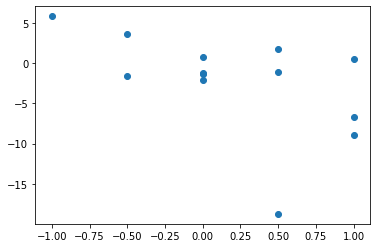

In [24]:
#print(data_info.query('has_left!=False'))
#print(float(data_info.query('filename=="1HB20_nuit_1.edf"')["Laterality"]))
for THR in THR_li:
    datas=[[],[]]
    for file in data_info["filename"]:
        #print(file)
        file_left = file+"_left"
        file_right = file+"_right"
        #print(float(data_info.query('filename==@file')["Laterality"]))
        #print(float(reports.query('filename==@file_right & THR_classif==@THR')["Number of MEMA episodes per hour"])
        #                - float(reports.query('filename==@file_left & THR_classif==@THR')["Number of MEMA episodes per hour"]))
        
        datas[0].append(float(data_info.query('filename==@file')["Laterality"]))
        datas[1].append(float(reports.query('filename==@file_right & THR_classif==@THR')["Number of MEMA episodes per hour"])
                        - float(reports.query('filename==@file_left & THR_classif==@THR')["Number of MEMA episodes per hour"]))
    plt.figure()
    plt.scatter(datas[0], datas[1])
    print(scipy.stats.spearmanr(datas[0],datas[1]))
    print(scipy.stats.linregress(datas[0],datas[1]))

## 

SpearmanrResult(correlation=0.3931068137707194, pvalue=0.18390883832531296)
LinregressResult(slope=4.121174309316119, intercept=2.124211847653366, rvalue=0.33008309798527186, pvalue=0.2706992358052332, stderr=3.5534581867841193)


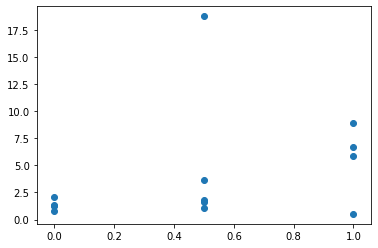

In [25]:
for THR in THR_li:
    datas=[[],[]]
    for file in data_info["filename"]:
        #print(file)
        file_left = file+"_left"
        file_right = file+"_right"
        #print(float(data_info.query('filename==@file')["Laterality"]))
        #print(float(reports.query('filename==@file_right & THR_classif==@THR')["Number of MEMA episodes per hour"])
        #                - float(reports.query('filename==@file_left & THR_classif==@THR')["Number of MEMA episodes per hour"]))
        
        datas[0].append(abs(float(data_info.query('filename==@file')["Laterality"])))
        datas[1].append(abs(float(reports.query('filename==@file_right & THR_classif==@THR')["Number of MEMA episodes per hour"])
                        - float(reports.query('filename==@file_left & THR_classif==@THR')["Number of MEMA episodes per hour"])))
    plt.figure()
    plt.scatter(datas[0], datas[1])
    print(scipy.stats.spearmanr(datas[0],datas[1]))
    print(scipy.stats.linregress(datas[0],datas[1]))

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Zeta\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Zeta\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


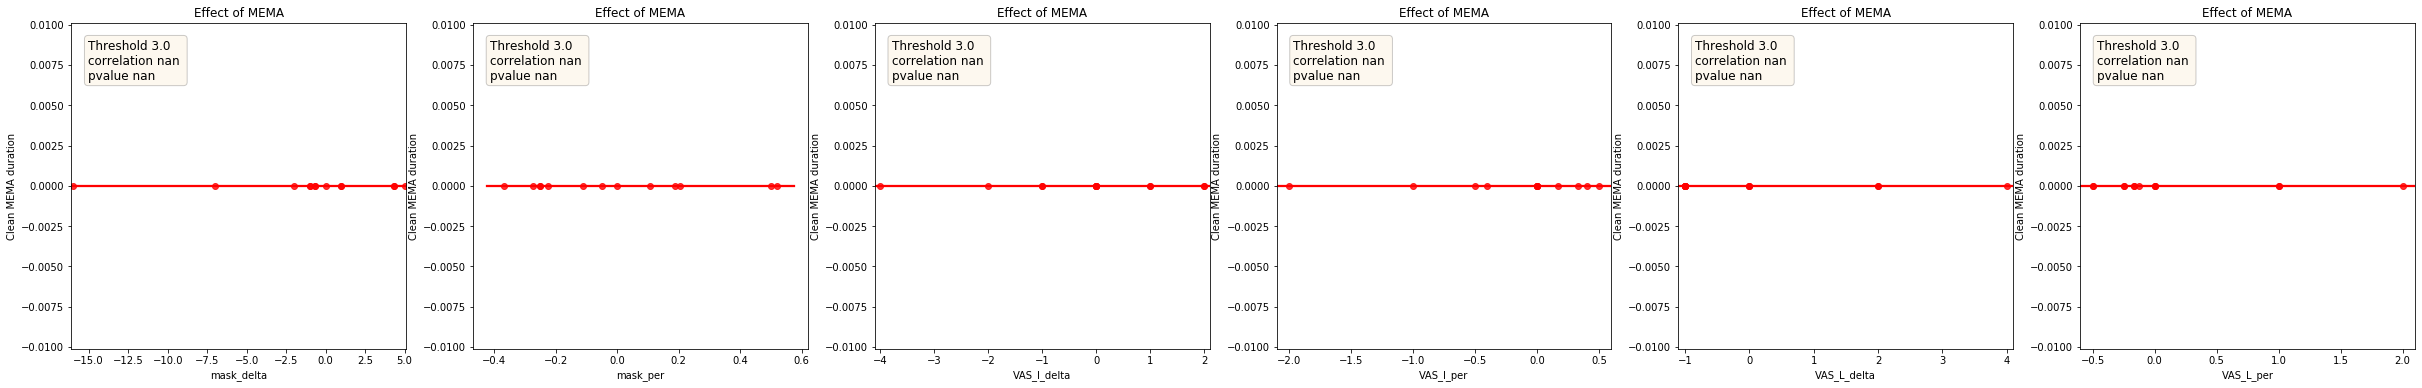

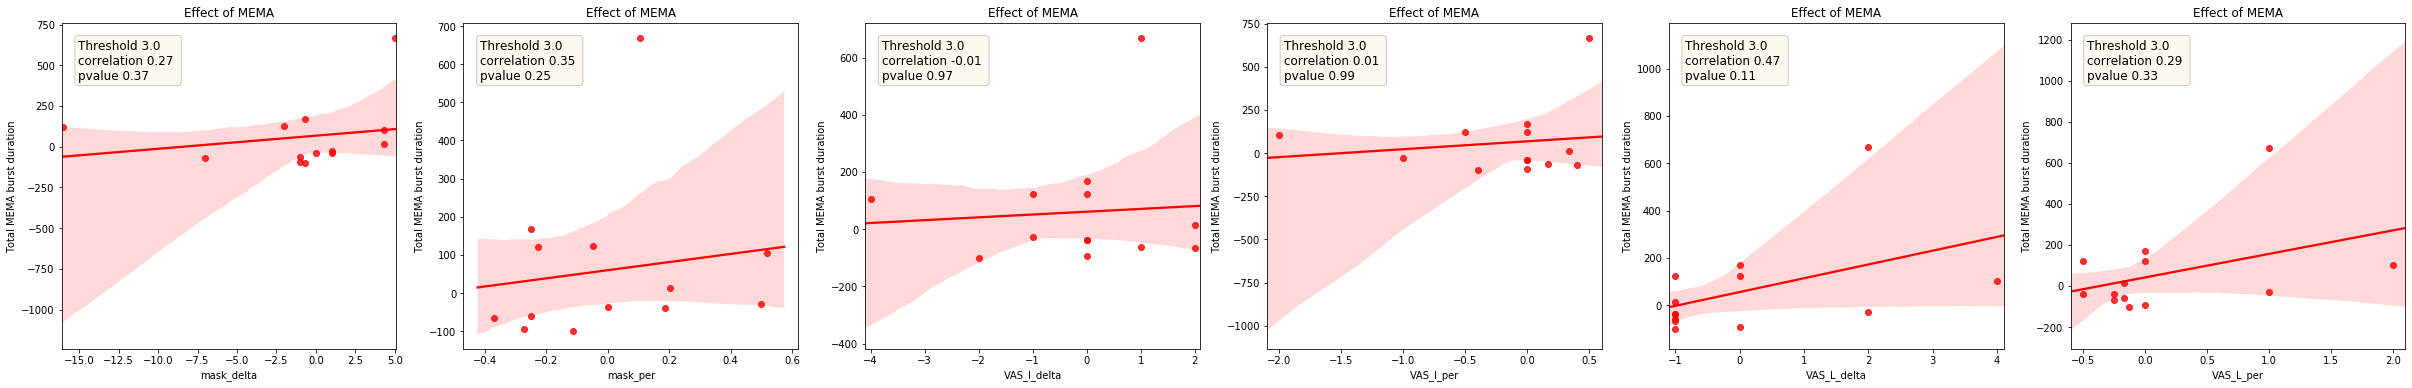

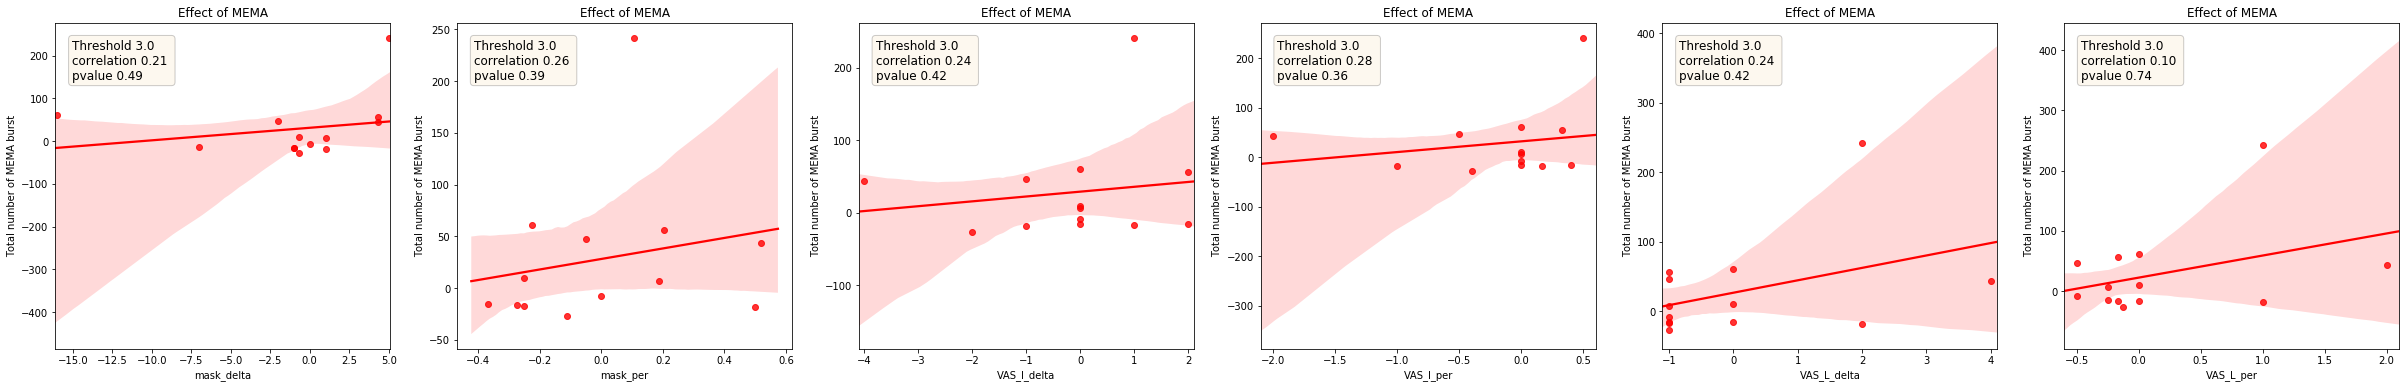

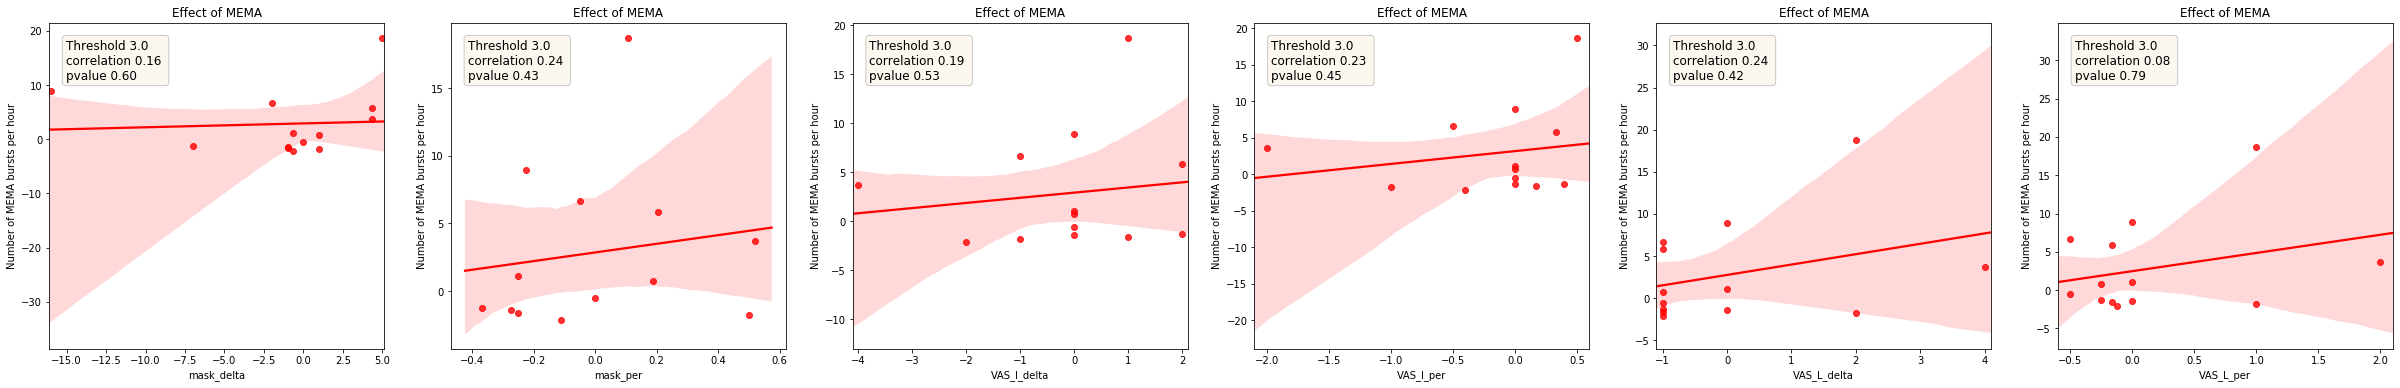

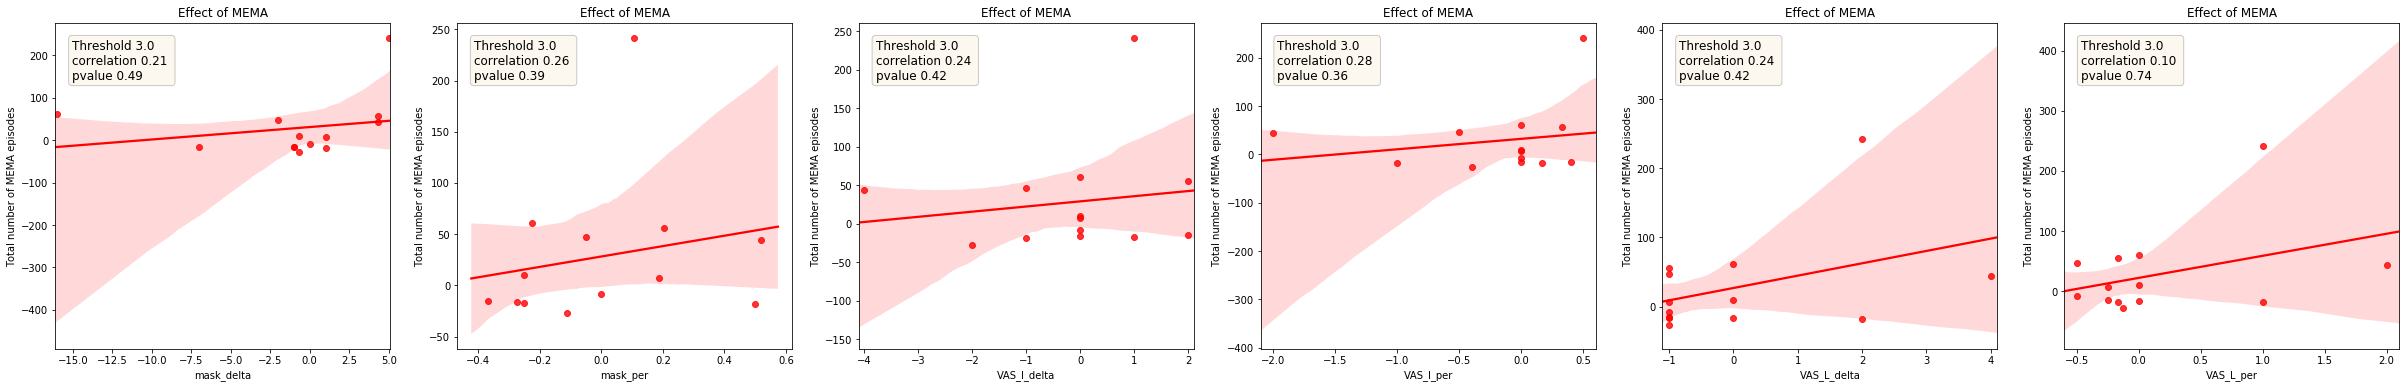

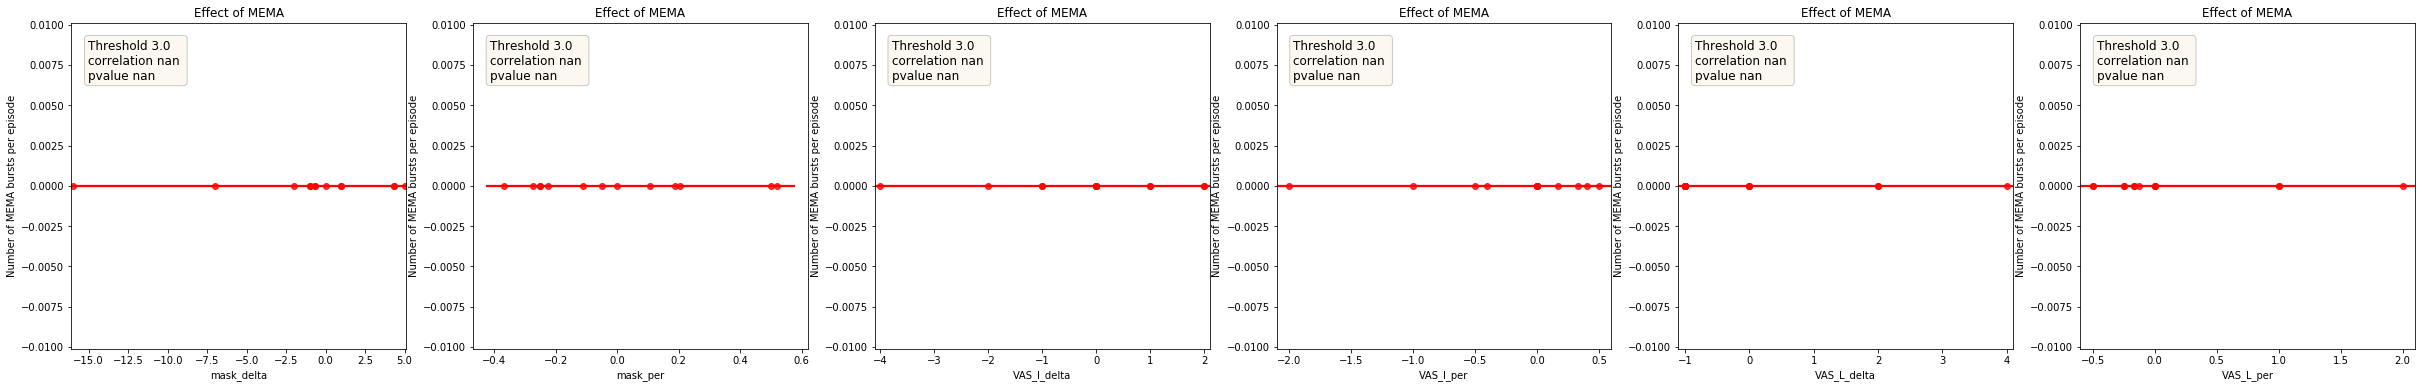

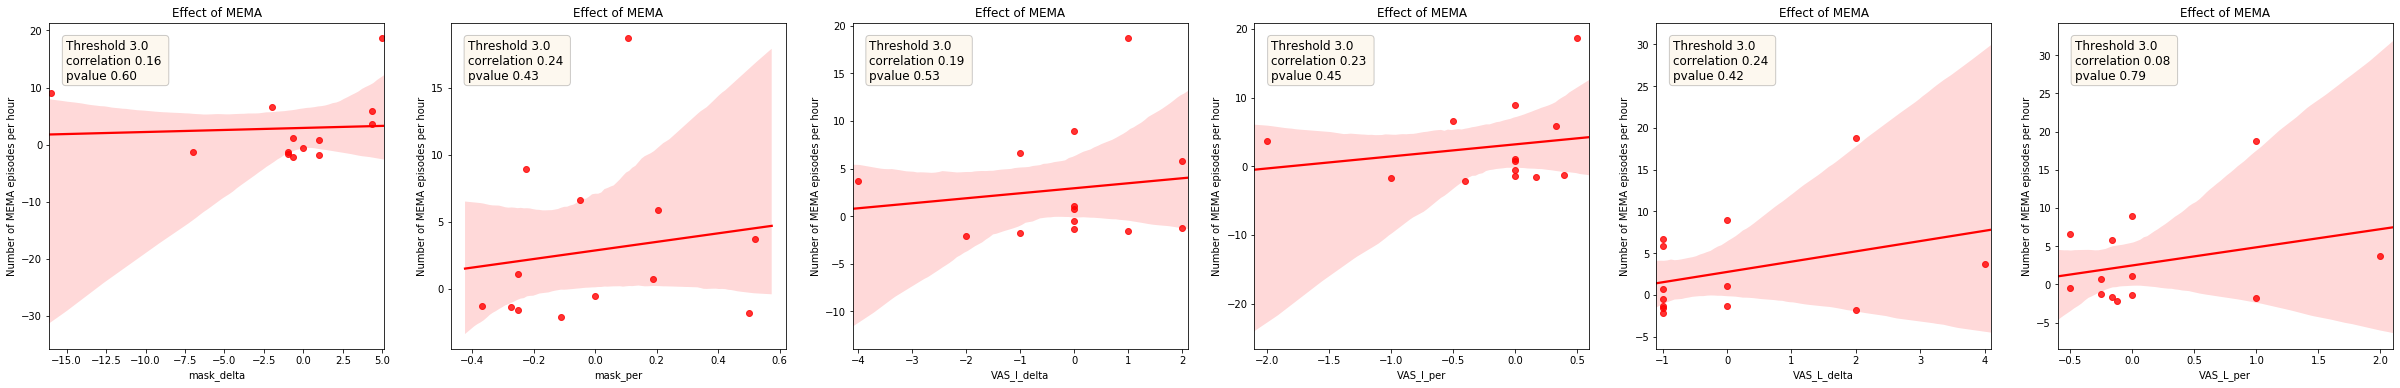

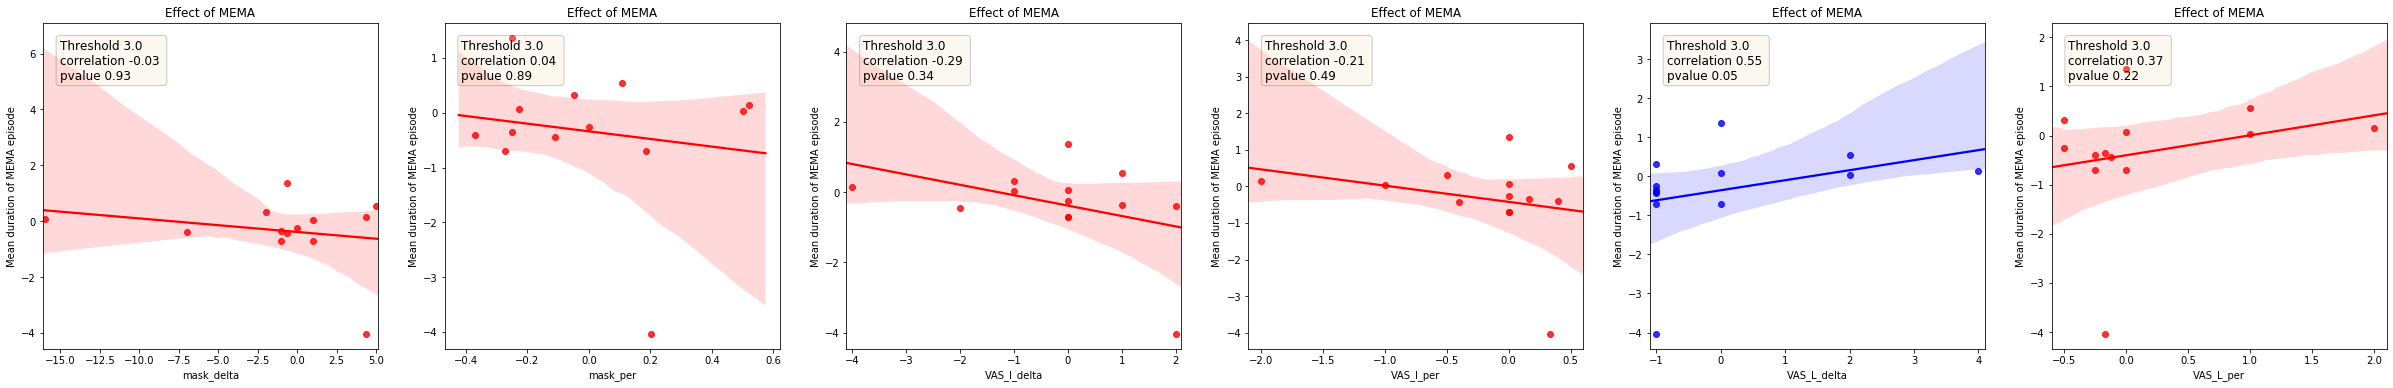

In [29]:
import seaborn as sns
meta_results = pd.DataFrame()
#criteria = "mask_per"
#variable = "Number of MEMA episodes per hour"
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys()) #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

for variable in quantitative_variables:
    for THR in THR_li:
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        for criteria, ax in zip(effect_variable, axes):
        #print(data_info.query('has_left!=False'))
        #print(float(data_info.query('filename=="1HB20_nuit_1.edf"')["Laterality"]))
        
            datas=[[],[]]
            for file in data_info["filename"]:
                #print(file)
                file_left = file+"_left"
                file_right = file+"_right"

                laterality = float(data_info.query('filename==@file')["Laterality"])
                diff_episodes = float(reports.query('filename==@file_right & THR_classif==@THR')[variable]) - float(reports.query('filename==@file_left & THR_classif==@THR')[variable])
                
                #ICI IMPORTANT DECIDER COMMENT FAIRE JOUER LA LATERALITE
                #diff_episodes = abs(diff_episodes)
                if laterality > 0:
                    diff_episodes = -diff_episodes

                datas[0].append(float(data_info.query('filename==@file')[criteria]))
                datas[1].append(diff_episodes)
                
            regression_result = scipy.stats.spearmanr(datas[0],datas[1])
            if regression_result.pvalue < 0.01:
                    color = 'g'
            elif regression_result.pvalue < 0.05:
                    color = 'b'
            else:
                    color = 'r'
            graph = sns.regplot(x=datas[0],y=datas[1],fit_reg=True, ax=ax,  color=color)
            graph.set_xlabel(criteria)
            graph.set_ylabel(variable)
            ax.set_xlim(min(datas[0])-0.1,max(datas[0])+0.1)
            tmp = {"x_axis":criteria, "y_axis":variable, "THR_classif": [THR]}
            textstr = f"Threshold {THR:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            #plt.figure()
            #plt.scatter(datas[0], datas[1])
            #print(scipy.stats.spearmanr(datas[0],datas[1]))
            #print(scipy.stats.linregress(datas[0],datas[1]))
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [30]:
meta_results.query("pvalue < 0.05") 

,x_axis,y_axis,THR_classif,correlation,pvalue
0,VAS_L_delta,Mean duration of MEMA episode,3,0.554046,0.04945


# Ici travailler à faire marcher tests de lateralité avec etiologies (notamment pour tester le cou

etiology (?) : 4, ['1HB20', '1SL21', '1UC22', '1ZN04']
etiology (group1) : 5, ['1HS25', '1RF29', '1DM32', '1NS30', '1AC26']
etiology (group3) : 4, ['3NS01', '3BS04', '3TR07', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_3 v.s. group1_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.986e-01 U_stat=1.800e+01
group1_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.340e-01 U_stat=1.700e+01
?_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.115e-02 U_stat=1.600e+01


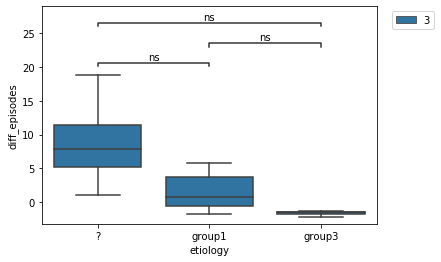

obstructed_ear (False) : 5, ['1HB20', '1HS25', '1RF29', '3TR07', '3HS08']
obstructed_ear (True) : 8, ['1SL21', '1UC22', '1ZN04', '3NS01', '1DM32', '3BS04', '1NS30', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.144e-01 U_stat=1.700e+01


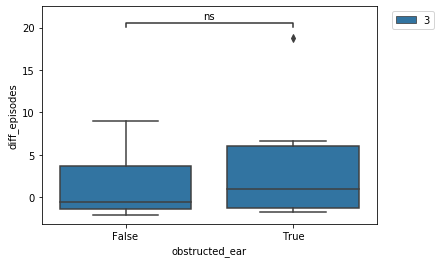

otalgy (False) : 10, ['1HB20', '1SL21', '1UC22', '1ZN04', '1HS25', '3NS01', '1RF29', '3BS04', '3TR07', '1NS30']
otalgy (True) : 3, ['1DM32', '1AC26', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.326e-01 U_stat=1.500e+01


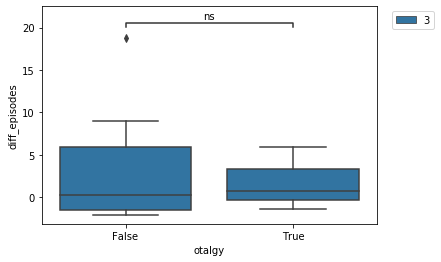

hyperacusis (False) : 9, ['1HB20', '1SL21', '1UC22', '1HS25', '3NS01', '3BS04', '3TR07', '1NS30', '1AC26']
hyperacusis (True) : 4, ['1ZN04', '1RF29', '1DM32', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.997e-01 U_stat=2.100e+01


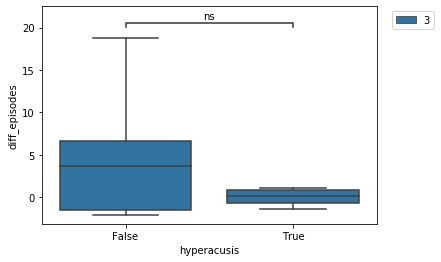

jaw_popping (False) : 5, ['1HB20', '1UC22', '1RF29', '3TR07', '1AC26']
jaw_popping (True) : 8, ['1SL21', '1ZN04', '1HS25', '3NS01', '1DM32', '3BS04', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.413e-01 U_stat=2.700e+01


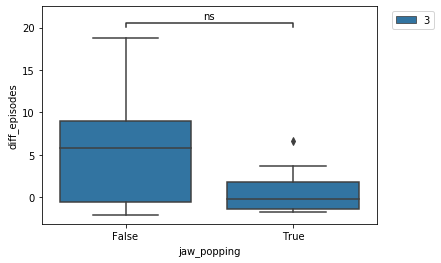

jaw_pain_and_fatigue (False) : 9, ['1HB20', '1SL21', '1UC22', '1ZN04', '3NS01', '1RF29', '3TR07', '1NS30', '3HS08']
jaw_pain_and_fatigue (True) : 4, ['1HS25', '1DM32', '3BS04', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.385e-01 U_stat=1.700e+01


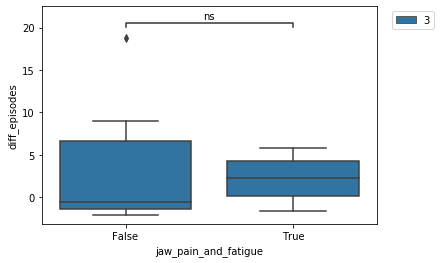

somatosensory_modulation (False) : 8, ['1HB20', '1SL21', '1ZN04', '3NS01', '1RF29', '1DM32', '1NS30', '3HS08']
somatosensory_modulation (True) : 5, ['1UC22', '1HS25', '3BS04', '3TR07', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.417e-01 U_stat=1.900e+01


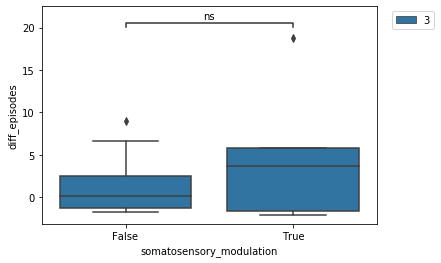

nap_modulation (True) : 5, ['1HB20', '1SL21', '1UC22', '1HS25', '1RF29']
nap_modulation (False) : 8, ['1ZN04', '3NS01', '1DM32', '3BS04', '3TR07', '1NS30', '1AC26', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.327e-02 U_stat=4.000e+00


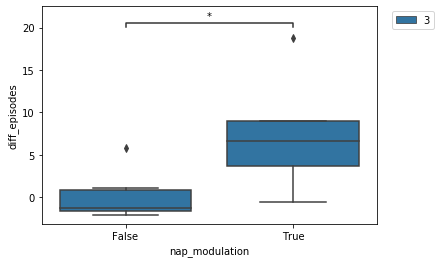

snoring (True) : 5, ['1HB20', '1SL21', '1UC22', '1RF29', '1AC26']
snoring (False) : 8, ['1ZN04', '1HS25', '3NS01', '1DM32', '3BS04', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.572e-02 U_stat=3.000e+00


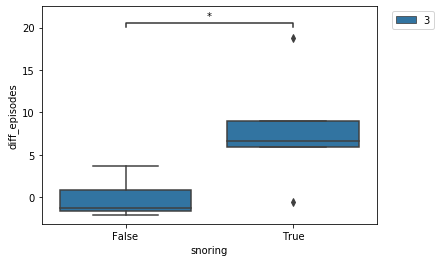

neck_pain (True) : 7, ['1HB20', '1HS25', '3NS01', '1RF29', '1DM32', '3BS04', '1AC26']
neck_pain (False) : 6, ['1SL21', '1UC22', '1ZN04', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.210e-01 U_stat=1.800e+01


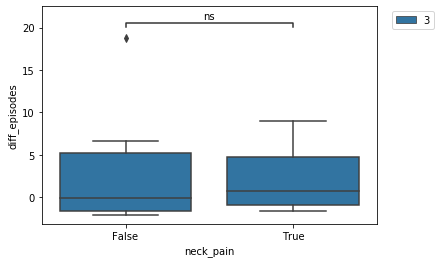

trauma_sonore (False) : 9, ['1HB20', '1SL21', '1ZN04', '1HS25', '3NS01', '1RF29', '1DM32', '3BS04', '1AC26']
trauma_sonore (True) : 4, ['1UC22', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.472e-01 U_stat=2.600e+01


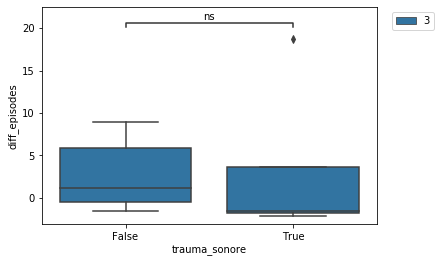

otite (True) : 6, ['1HB20', '1SL21', '1UC22', '1ZN04', '1RF29', '1AC26']
otite (False) : 7, ['1HS25', '3NS01', '1DM32', '3BS04', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.242e-02 U_stat=3.000e+00


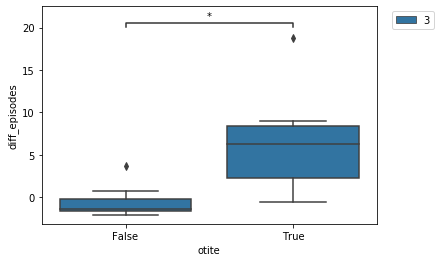

Ear clapping (False) : 6, ['1HB20', '1SL21', '1HS25', '1DM32', '3BS04', '3TR07']
Ear clapping (True) : 7, ['1UC22', '1ZN04', '3NS01', '1RF29', '1NS30', '1AC26', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.431e-01 U_stat=2.200e+01


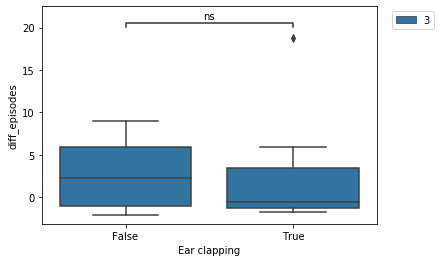

In [31]:
# e.1 GROUP BY ETIOLOGIES
from itertools import combinations
from statannot import add_stat_annotation
test='Mann-Whitney'
hue_value_for_stats=None
plt.close("all")
from tinnsleep.visualization import etiology_report_with_plot

variable = "Number of MEMA episodes per hour"
data_info["diff_episodes"] = data_info["to_suppress"]
#print(data_info["diff_episodes"])
data_info["THR_classif"] = data_info["THR_IMP"]


for THR in THR_li:

    for file in data_info["filename"]:
        #print(file)
        file_left = file+"_left"
        file_right = file+"_right"

        laterality = float(data_info.query('filename==@file')["Laterality"])
        diff_episodes = float(reports.query('filename==@file_right & THR_classif==@THR')[variable]) - float(reports.query('filename==@file_left & THR_classif==@THR')[variable])

        
        
        #ICI IMPORTANT DECIDER COMMENT FAIRE JOUER LA LATERALITE
        #diff_episodes = abs(diff_episodes)
        if laterality > 0:
            diff_episodes = -diff_episodes
            
            
        index = int(data_info.query('filename == @file').index.values)
        data_info.loc[index, "diff_episodes"] = diff_episodes
        data_info.loc[index, "THR_classif"] = THR
    #print(data_info["diff_episodes"])
    
    variable2 = "diff_episodes"
    hue = "THR_classif"
    etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
                'somatosensory_modulation', 'nap_modulation', 'snoring', "neck_pain", "trauma_sonore", "otite",
                 "Ear clapping"]

    for etiology in etiologies:
        # e.1 prepare data
        categories = list(data_info[etiology].unique())

        assert len(categories) > 1, f"etiology {etiology} have only one type: {categories} "
        for category in categories:
            # Display list of subject for each category
            print(f"{etiology} ({category}) : "
                  f"{(data_info[etiology] == category).sum()}, {(list(data_info[data_info[etiology] == category]['subject']))}")

       # e.2 Display
        plt.figure()
        ax = sns.boxplot(data=data_info, x=etiology, y=variable2, hue=hue)
        if hue is not None:
            plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

        # e.3 Statistical results
        box_pairs = []
        if hue is not None:
            
            hue_value_for_stats = THR  # do only the first one to avoid clunky the interface
            for pair_ in list(combinations(categories, 2)):
                box_pairs.append(((pair_[0], hue_value_for_stats), (pair_[1], hue_value_for_stats)))
            

        add_stat_annotation(ax, data=data_info, x=etiology, y=variable2, box_pairs=box_pairs, hue=hue,
                                         test=test, loc='inside', verbose = 2)
        plt.show()

## Proof of no differences between MEMA sensors measurements

In [68]:
results_file_mema = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file_mema).to_dict()
print(results.keys())
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])
results_update=dict()
# e.1 GROUP BY ETIOLOGIES
from tinnsleep.data import read_etiology_file
etiology_file = "data/etiology.xlsx"
etiology = read_etiology_file(etiology_file)



data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & emg==1')
data_info = data_info.merge(etiology,on="subject")

laterality_study=[]
# format reports
reports = None
for filename in results.keys():
    if filename[-4:]=="left":
        if filename!="1SL21_nuit_3.edf_left":
            if filename!='1CB23_cohort2.edf_left':
                if filename!='1HB20_nuit_2.edf_left':
                    if filename!='1UC22_nuit_2.edf_left':
                        if filename!='3KB06_cohort2.edf_left':
                            if filename!='2TL07_nuit_1.edf_left':
                                if filename!="1SL21_nuit_2.edf_left":
                                    if filename!='1HB20_nuit_1.edf_left':
                                        if filename!='1UC22_nuit_1.edf_left':
                                            laterality_study.append(filename[:-5])
print(laterality_study)
#print(results.keys())
        
for filename in results.keys():
    if filename[-4:]=="left" or filename[-5:]=="right" or filename == '1HB20_nuit_1.edf' or filename == '1SL21_nuit_2.edf' or filename == '1UC22_nuit_1.edf':
        
        report = pd.DataFrame(results[filename]["reports"])
        report["THR_classif"] = THR_classif[:,1]
        if filename == '1HB20_nuit_1.edf' or filename == '1SL21_nuit_2.edf' or filename == '1UC22_nuit_1.edf':
            report["filename"] = filename+"_right"
        else:
            report["filename"] = filename
        #if filename[:5] == "2TL07":
        #    print(results[filename]["reports"])
        results_update[filename]=results[filename]
        if reports is None:
            reports = report
        else:
            reports = reports.append(report, ignore_index=True)
    
#print(laterality_study)
print(reports[["filename", "Number of MEMA episodes per hour" ]])

data_info["has_left"] = data_info["filename"]
for col_name, data in data_info["filename"].items():
    if laterality_study.__contains__(data):
        data_info["has_left"][col_name]=data+"_left"
    else:
        data_info["has_left"][col_name]=False


data_info = data_info.query('has_left!=False')
print(data_info[["filename", "condition", "mema", "emg","Laterality", "VAS_L_delta", "has_left"]])
results=results_update
#print(data_info)


dict_keys(['1AC26_cohort2.edf_right', '1AC26_cohort2.edf_left', '1AC26_cohort2.edf', '1CB23_cohort2.edf_right', '1CB23_cohort2.edf_left', '1CB23_cohort2.edf', '1DA15_nuit_hab.edf', '1DM32_cohort2.edf_right', '1DM32_cohort2.edf_left', '1DM32_cohort2.edf', '1GB18_nuit_hab.edf', '1GF14_cohort2.edf', '1HB20_nuit_1.edf', '1HB20_nuit_1.edf_left', '1HB20_nuit_2.edf', '1HB20_nuit_2.edf_left', '1HS25_cohort2.edf_right', '1HS25_cohort2.edf_left', '1HS25_cohort2.edf', '1NS30_cohort2.edf_right', '1NS30_cohort2.edf_left', '1NS30_cohort2.edf', '1PA31_cohort2.edf', '1RF29_cohort2.edf_right', '1RF29_cohort2.edf_left', '1RF29_cohort2.edf', '1SL21_nuit_2.edf', '1SL21_nuit_2.edf_left', '1SL21_nuit_3.edf', '1SL21_nuit_3.edf_left', '1SL21_nuit_6.edf', '1SL21_nuit_7.edf', '1SL21_nuit_8.edf', '1UC22_nuit_1.edf', '1UC22_nuit_1.edf_left', '1UC22_nuit_2.edf', '1UC22_nuit_2.edf_left', '1ZN04_cohort2.edf_right', '1ZN04_cohort2.edf_left', '1ZN04_cohort2.edf', '2CT04_nuit_1.edf', '2GR01_nuit_3.edf', '2GR01_nuit_4.e

C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Zeta\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


             filename condition  mema  emg  Laterality  VAS_L_delta  \
21  1ZN04_cohort2.edf    batch2     1    1         0.5          0.0   
22  1HS25_cohort2.edf    batch2     1    1        -0.5          4.0   
24  1RF29_cohort2.edf    batch2     1    1         1.0         -1.0   
26  1DM32_cohort2.edf    batch2     1    1         0.0         -1.0   
27  3BS04_cohort2.edf    batch2     1    1        -0.5         -1.0   
28  3TR07_cohort2.edf    batch2     1    1         0.0         -1.0   
30  1NS30_cohort2.edf    batch2     1    1         0.5          2.0   
31  1AC26_cohort2.edf    batch2     1    1        -1.0         -1.0   
33  3HS08_cohort2.edf    batch2     1    1         0.0          0.0   

                  has_left  
21  1ZN04_cohort2.edf_left  
22  1HS25_cohort2.edf_left  
24  1RF29_cohort2.edf_left  
26  1DM32_cohort2.edf_left  
27  3BS04_cohort2.edf_left  
28  3TR07_cohort2.edf_left  
30  1NS30_cohort2.edf_left  
31  1AC26_cohort2.edf_left  
33  3HS08_cohort2.edf_left  

21    0.5
22   -0.5
24    1.0
26    0.0
27   -0.5
28    0.0
30    0.5
31   -1.0
33    0.0
Name: Laterality, dtype: float64
Index(['filename', 'subject', 'session', 'condition', 'emg', 'mema',
       'pression diff', 'mask pressure', 'airflow', 'Machoire 1', 'Machoire 2',
       'Masseter g', 'Masseter d', 'comments', 'included', 'control',
       'mask_delta', 'mask_per', 'VAS_L_delta', 'VAS_L_per', 'VAS_I_delta',
       'VAS_I_per', 'Valid_chans', 'Valid_imps', 'THR_IMP', 'Masking_before',
       'VAS_L_before', 'VAS_I_before', 'Masking_after', 'VAS_L_after',
       'VAS_I_after', 'Laterality', 'etiology', 'to_suppress', 'Ear_select',
       'Controlateral', 'THR', 'diff_episodes', 'obstructed_ear', 'otalgy',
       'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 'neck_pain',
       'somatosensory_modulation', 'nap_modulation', 'snoring',
       'trauma_sonore', 'otite', 'Ear clapping', 'has_left'],
      dtype='object')
1ZN04_cohort2.edf
-1.3329370725344862
1HS25_cohort2.edf
3.

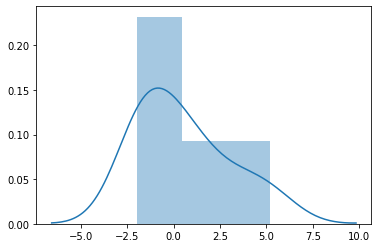

In [71]:
print(data_info.query('has_left!=False')["Laterality"])
print(data_info.keys())
#print(float(data_info.query('filename=="1HB20_nuit_1.edf"')["Laterality"]))
variable = 'Number of MEMA bursts per hour'
for THR in THR_li:
    datas=[[],[]]
    for file in data_info["filename"]:
        print(file)
        file_left = file+"_left"
        file_right = file+"_right"
        
        print(float(reports.query('filename==@file_right & THR_classif==@THR')[variable])
                        - float(reports.query('filename==@file_left & THR_classif==@THR')[variable]))
        
        datas[0].append(0)
        datas[1].append(float(reports.query('filename==@file_right & THR_classif==@THR')[variable])
                        - float(reports.query('filename==@file_left & THR_classif==@THR')[variable]))
    plt.figure()
    sns.distplot(datas[1])
    print(scipy.stats.normaltest(datas[1]))
    print(scipy.stats.ttest_1samp(datas[1],0))
    print(scipy.stats.wilcoxon(datas[1]))
    

In [54]:
data_info = pd.read_csv(info_file, sep=";").query("session == '1' & emg==1")
print(data_info["subject"].unique())
print(len(data_info["subject"]))

['1BA07' '1CC05' '1DA15' '1DL12' '1GB18' '1MF19' '1MN09' '1PI07' '1PT06'
 '1SA14' '1ZN04' '1HB20' '1SL21' '1UC22' '2SJ03' '2GR01' '2LS05' '2CT04'
 '1HS25' '1PA31' '1RF29' '1GF14' '1DM32' '3BS04' '3TR07' '3KB06' '1NS30'
 '1AC26' '3TS03' '3HS08' '2TL07']
32


In [59]:
data_info = pd.read_csv(info_file, sep=";").query("session == '1' & mema==1")
print(data_info["subject"])
print(len(data_info["subject"]))

4     1DA15
9     1GB18
22    1RA17
28    1HB20
36    1SL21
40    1UC22
42    2GA06
43    2SJ03
49    2LS05
50    2CT04
57    1ZN04
58    1HS25
59    1PA31
60    3NS01
62    1RF29
63    1GF14
64    1DM32
65    3BS04
66    3TR07
67    3KB06
68    1NS30
69    1AC26
71    3TS03
72    3HS08
73    2TL07
Name: subject, dtype: object
25
